### Check differentiability of the code!

This notebook checks that the differentiability of the code.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
from jax import config
from jax import grad, jit, vmap
# import jaxopt

config.update("jax_enable_x64", True)

True


model params:

In [2]:
signal_params = ConfigDict(KDV_params_2)
signal_params.update(E=1,method='Dealiased_ETDRK4',nx = 128,P=0,S=0)
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
final, all = signal_model.run(initial_signal, signal_model.nmax, None)


In [3]:
forward_model_params = ConfigDict(KDV_params_2)
forward_model_params.update(E=1,method='Dealiased_ETDRK4',nx = 128,P=0,S=0)
forward_model = ETD_KT_CM_JAX_Vectorised(signal_params)

# Randomly initialize the initial conditions for the forward model
key = jax.random.PRNGKey(0)
random_initial_conditions = initial_signal + 0.1*jnp.sin(8*jnp.pi*signal_model.x) 

# Define the loss function as the L2 error between the forward model's final state and the signal model's final state
def loss_fn(initial_conditions):
    forward_final, _ = forward_model.run(initial_conditions, forward_model.nmax, None)
    return jnp.linalg.norm(forward_final - final)

# Compute the gradient of the loss function with respect to the initial conditions
grad_loss_fn = grad(loss_fn)

# Perform gradient descent to minimize the loss
learning_rate = 0.001
num_iterations = 100
optimized_initial_conditions = random_initial_conditions
for i in range(num_iterations):
    loss = loss_fn(optimized_initial_conditions)
    print(f"Iteration {i}, Loss: {loss}")
    gradients = grad_loss_fn(optimized_initial_conditions)
    optimized_initial_conditions -= learning_rate * gradients

# The optimized initial conditions are now stored in `optimized_initial_conditions`

Iteration 0, Loss: 3.610196298295753
Iteration 1, Loss: 3.262195260535672
Iteration 2, Loss: 2.9033423476360825
Iteration 3, Loss: 2.6126700598194046
Iteration 4, Loss: 2.4224877884177882
Iteration 5, Loss: 2.2876920727101053
Iteration 6, Loss: 2.1637804365172704
Iteration 7, Loss: 2.0356803055969572
Iteration 8, Loss: 1.9014021152623675
Iteration 9, Loss: 1.7627178021407244
Iteration 10, Loss: 1.622921387056181
Iteration 11, Loss: 1.4863011168656655
Iteration 12, Loss: 1.3576968801693052
Iteration 13, Loss: 1.2418466044266887
Iteration 14, Loss: 1.1424866920937744
Iteration 15, Loss: 1.0614011536007035
Iteration 16, Loss: 0.9979874030131641
Iteration 17, Loss: 0.949757024114243
Iteration 18, Loss: 0.9134165427975766
Iteration 19, Loss: 0.8858065174054872
Iteration 20, Loss: 0.8643613625137544
Iteration 21, Loss: 0.8471886422011252
Iteration 22, Loss: 0.8329708650169778
Iteration 23, Loss: 0.8208222952118289
Iteration 24, Loss: 0.8101587881772023
Iteration 25, Loss: 0.8005976655683136


In [4]:
# Define the loss function as the L2 error between the forward model's final state and the signal model's final state
@jit
def loss_fn(initial_conditions):
    forward_final, _ = forward_model.run(initial_conditions, forward_model.nmax, None)
    return jnp.linalg.norm(forward_final - final)

# Compute the gradient of the loss function with respect to the initial conditions
@jit
def compute_gradients(initial_conditions):
    return grad(loss_fn)(initial_conditions)

# Perform gradient descent to minimize the loss
@jit
def optimize(initial_conditions, learning_rate):
    gradients = compute_gradients(initial_conditions)
    updated_conditions = initial_conditions - learning_rate * gradients
    loss = loss_fn(updated_conditions)
    return updated_conditions, loss

# Initialize variables for optimization
optimized_initial_conditions = random_initial_conditions
learning_rate = 0.001
num_iterations = 1000
# Optimization loop
for i in range(num_iterations):
    optimized_initial_conditions, loss = optimize(optimized_initial_conditions, learning_rate)
    print(f"Iteration {i}, Loss: {loss}")

# The optimized initial conditions are now stored in `optimized_initial_conditions`

Iteration 0, Loss: 3.2621952605357007
Iteration 1, Loss: 2.903342347636115
Iteration 2, Loss: 2.6126700598194543
Iteration 3, Loss: 2.4224877884177674
Iteration 4, Loss: 2.287692072710135
Iteration 5, Loss: 2.163780436517281
Iteration 6, Loss: 2.0356803055969905
Iteration 7, Loss: 1.9014021152623828
Iteration 8, Loss: 1.7627178021407321
Iteration 9, Loss: 1.6229213870561459
Iteration 10, Loss: 1.4863011168656546
Iteration 11, Loss: 1.3576968801693032
Iteration 12, Loss: 1.2418466044267
Iteration 13, Loss: 1.1424866920938395
Iteration 14, Loss: 1.0614011536007617
Iteration 15, Loss: 0.99798740301317
Iteration 16, Loss: 0.949757024114235
Iteration 17, Loss: 0.9134165427975569
Iteration 18, Loss: 0.8858065174054468
Iteration 19, Loss: 0.8643613625137233
Iteration 20, Loss: 0.8471886422011604
Iteration 21, Loss: 0.8329708650170081
Iteration 22, Loss: 0.8208222952118365
Iteration 23, Loss: 0.8101587881771866
Iteration 24, Loss: 0.8005976655683165
Iteration 25, Loss: 0.7918870589248895
Itera

In [5]:
!pip3 install optax

/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [optax]32m3/4 [optax]


In [6]:
import optax
# Define the optimizer
optimizer = optax.adam(learning_rate)

# Initialize the optimizer state
opt_state = optimizer.init(random_initial_conditions)

# Optimization loop using Adam
optimized_initial_conditions = random_initial_conditions
for i in range(num_iterations):
    loss, gradients = jax.value_and_grad(loss_fn)(optimized_initial_conditions)
    updates, opt_state = optimizer.update(gradients, opt_state)
    optimized_initial_conditions = optax.apply_updates(optimized_initial_conditions, updates)
    print(f"Iteration {i}, Loss: {loss}")

# The optimized initial conditions are now stored in `optimized_initial_conditions`

Iteration 0, Loss: 3.610196298295727
Iteration 1, Loss: 3.502871431704984
Iteration 2, Loss: 3.391537612238881
Iteration 3, Loss: 3.276569360874353
Iteration 4, Loss: 3.158473348346126
Iteration 5, Loss: 3.037866263822049
Iteration 6, Loss: 2.9154393228849163
Iteration 7, Loss: 2.7919783059222927
Iteration 8, Loss: 2.668336894369873
Iteration 9, Loss: 2.545379751773977
Iteration 10, Loss: 2.423983459420247
Iteration 11, Loss: 2.3049733595440993
Iteration 12, Loss: 2.1890109683267522
Iteration 13, Loss: 2.076516809199926
Iteration 14, Loss: 1.9676165985355643
Iteration 15, Loss: 1.8621370162859734
Iteration 16, Loss: 1.7597021888227056
Iteration 17, Loss: 1.6598923038597064
Iteration 18, Loss: 1.5623904404620832
Iteration 19, Loss: 1.4670961515735996
Iteration 20, Loss: 1.3742275411891847
Iteration 21, Loss: 1.2844275673157246
Iteration 22, Loss: 1.1988564031174527
Iteration 23, Loss: 1.1192084313664439
Iteration 24, Loss: 1.047549620050595
Iteration 25, Loss: 0.9858690880886669
Iterati

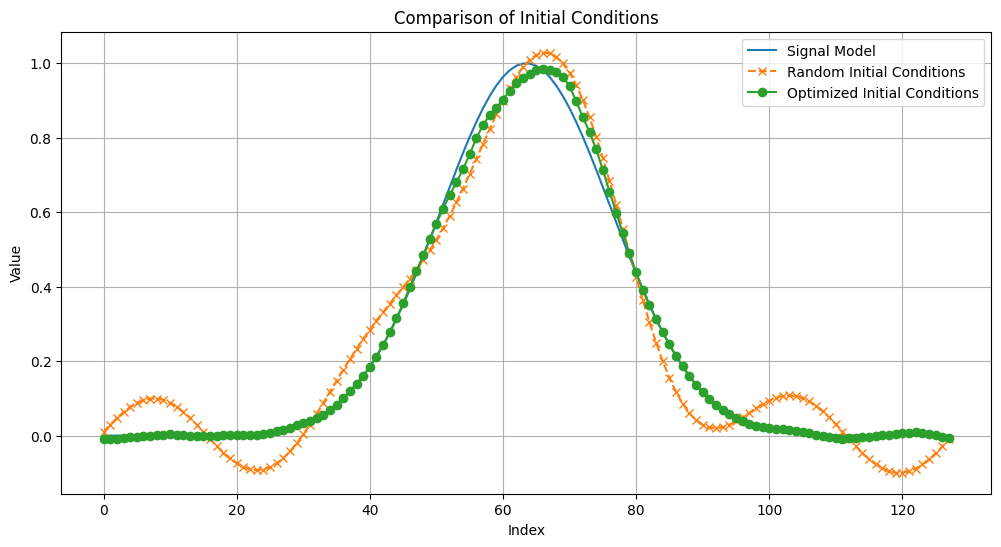

In [8]:
plt.figure(figsize=(12, 6))

# Plot random initial conditions
plt.plot(initial_signal[0] , label='Signal Model', linestyle='-')
plt.plot(random_initial_conditions[0], label='Random Initial Conditions', linestyle='--',marker='x')

# Plot optimized initial conditions
plt.plot(optimized_initial_conditions[0], label='Optimized Initial Conditions', linestyle='-',marker='o')

plt.title('Comparison of Initial Conditions')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

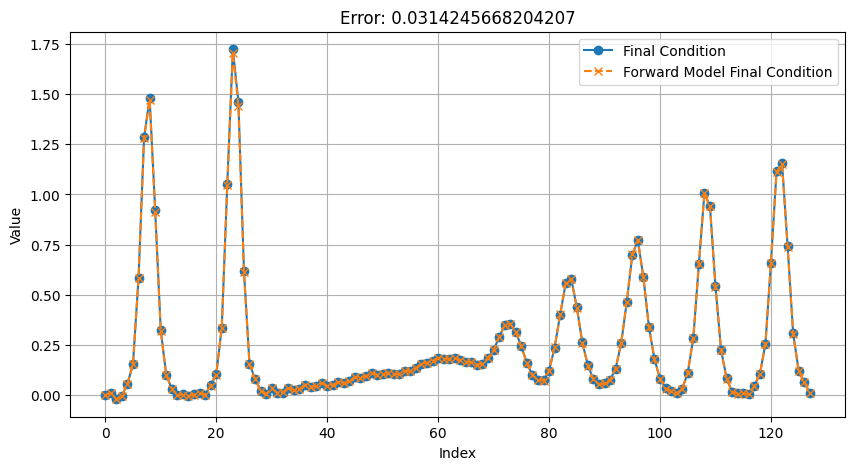

In [13]:
new_initial_conditions = optimized_initial_conditions
# Run the forward model with the optimized initial conditions
forward_final, _ = signal_model.run(new_initial_conditions, forward_model.nmax, None)

plt.figure(figsize=(10, 5))
plt.plot(final[0], label='Final Condition', linestyle='-', marker='o')
plt.plot(forward_final[0], label='Forward Model Final Condition', linestyle='--', marker='x')
plt.title('Final Condition')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.title('Error: ' + str(jnp.linalg.norm(forward_final - final)))
plt.show()